Epoch 4999: D (0.04 real_err, 0.03 fake_err) G (4.41 err); Real Dist ([4.04, 0.96]),  Fake Dist ([13.64, 4.09])


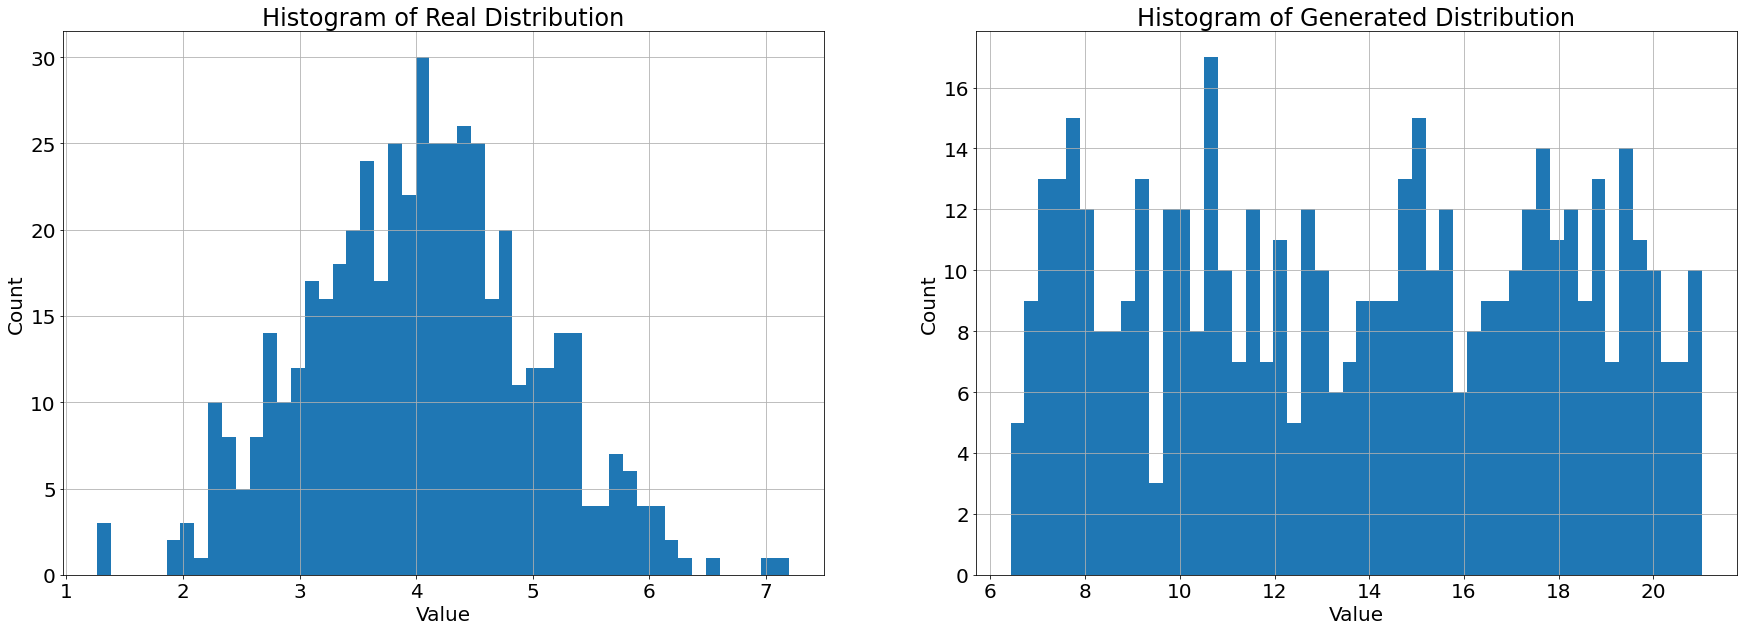

Epoch 9999: D (0.78 real_err, 0.71 fake_err) G (0.72 err); Real Dist ([3.9, 0.99]),  Fake Dist ([4.23, 1.18])


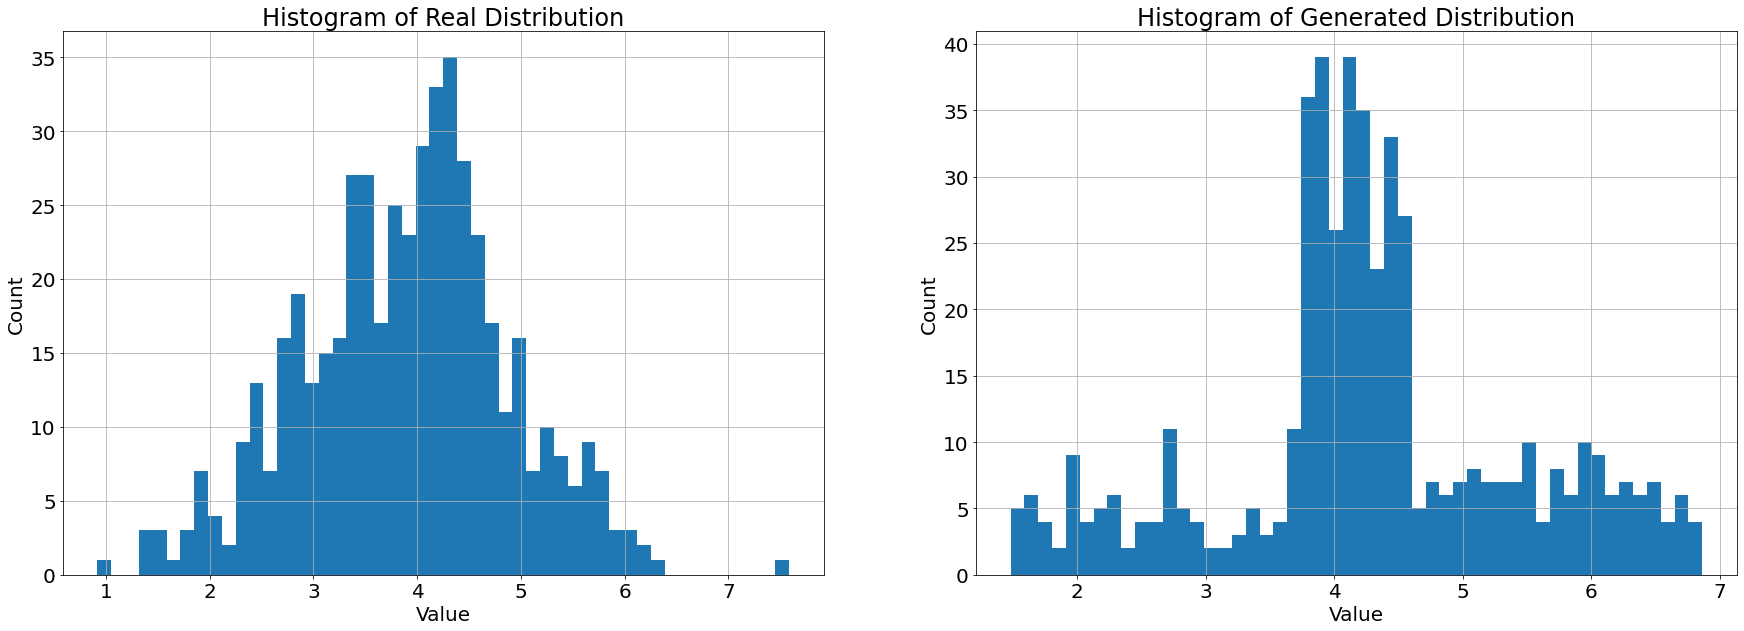

Epoch 14999: D (0.7 real_err, 0.73 fake_err) G (0.65 err); Real Dist ([4.03, 0.99]),  Fake Dist ([4.04, 0.9])


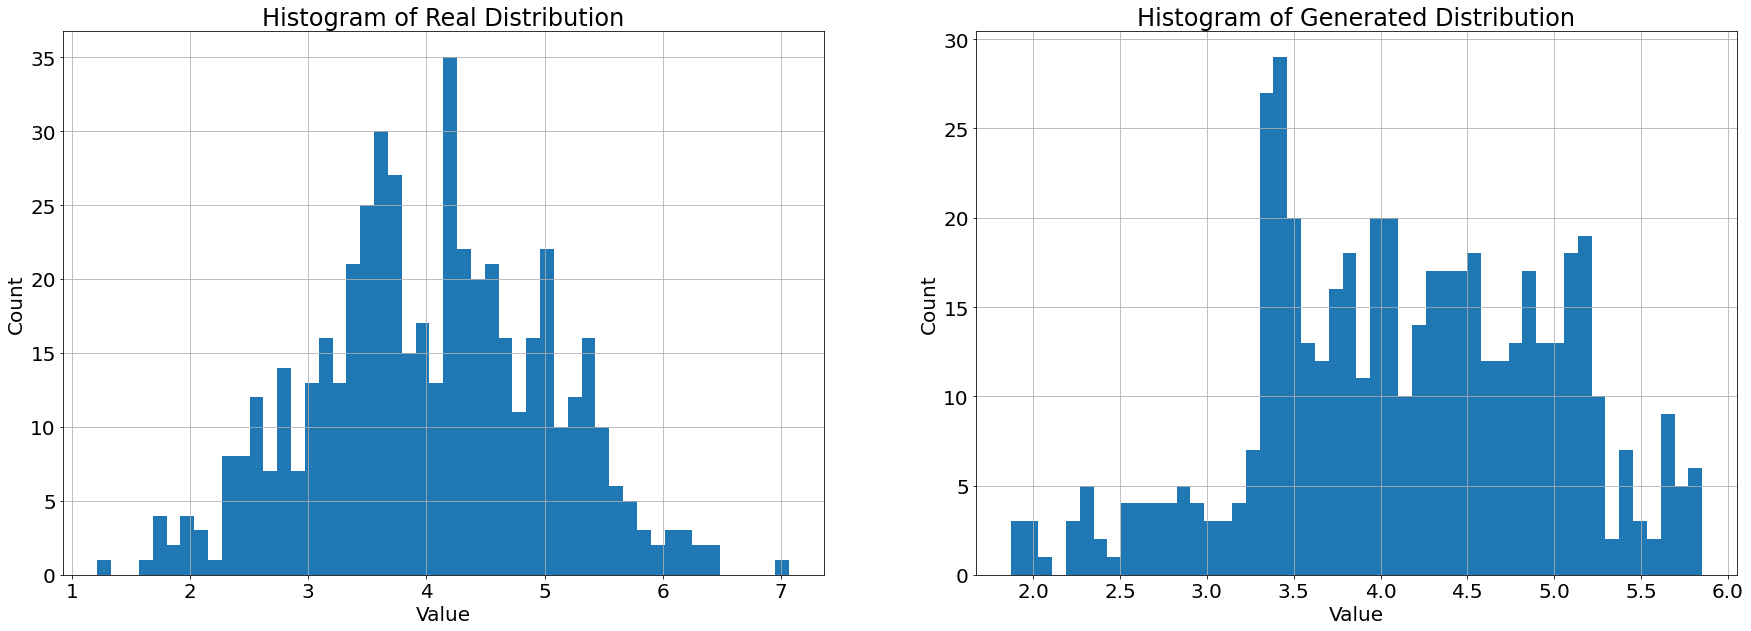

Epoch 19999: D (0.71 real_err, 0.67 fake_err) G (0.72 err); Real Dist ([3.97, 0.99]),  Fake Dist ([4.12, 1.01])


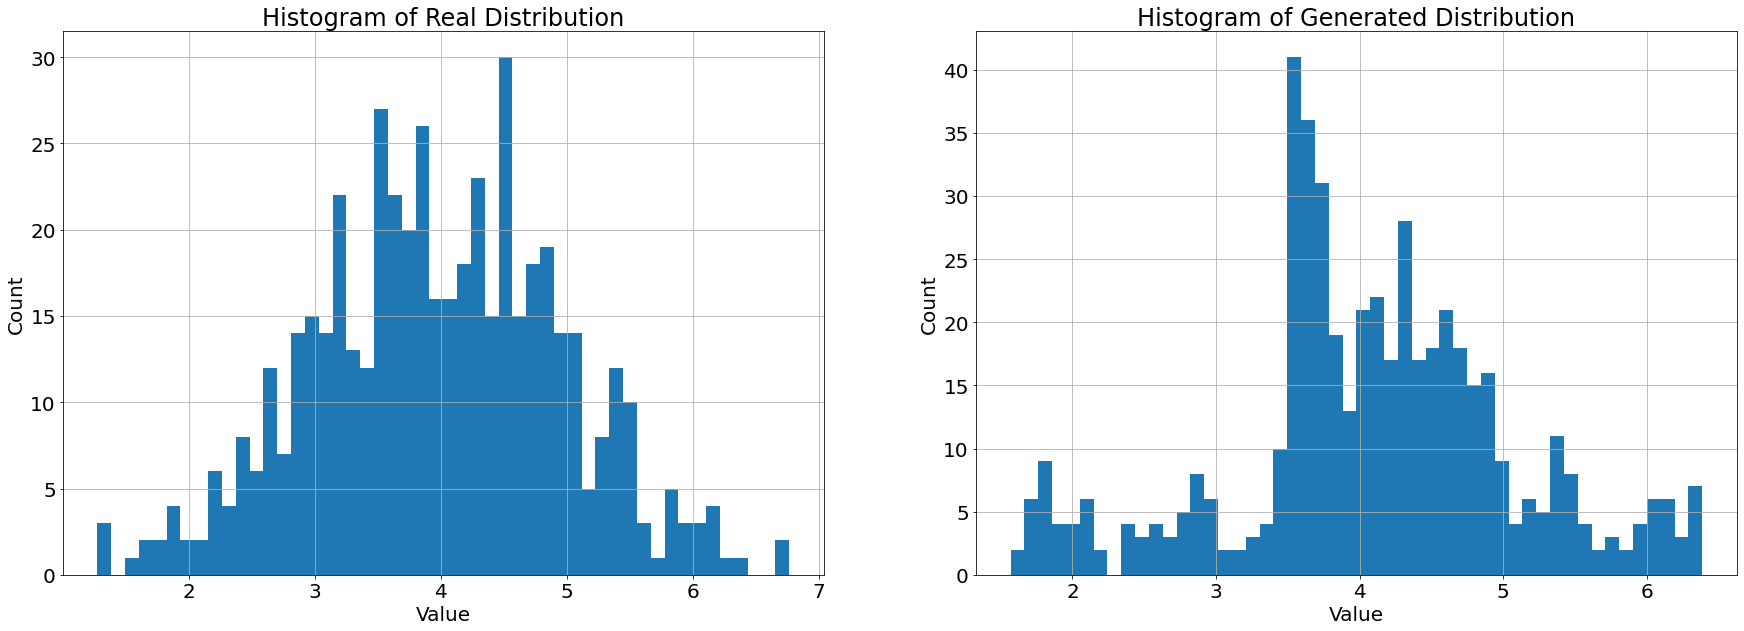

Epoch 24999: D (0.7 real_err, 0.69 fake_err) G (0.7 err); Real Dist ([4.0, 1.01]),  Fake Dist ([4.04, 0.97])


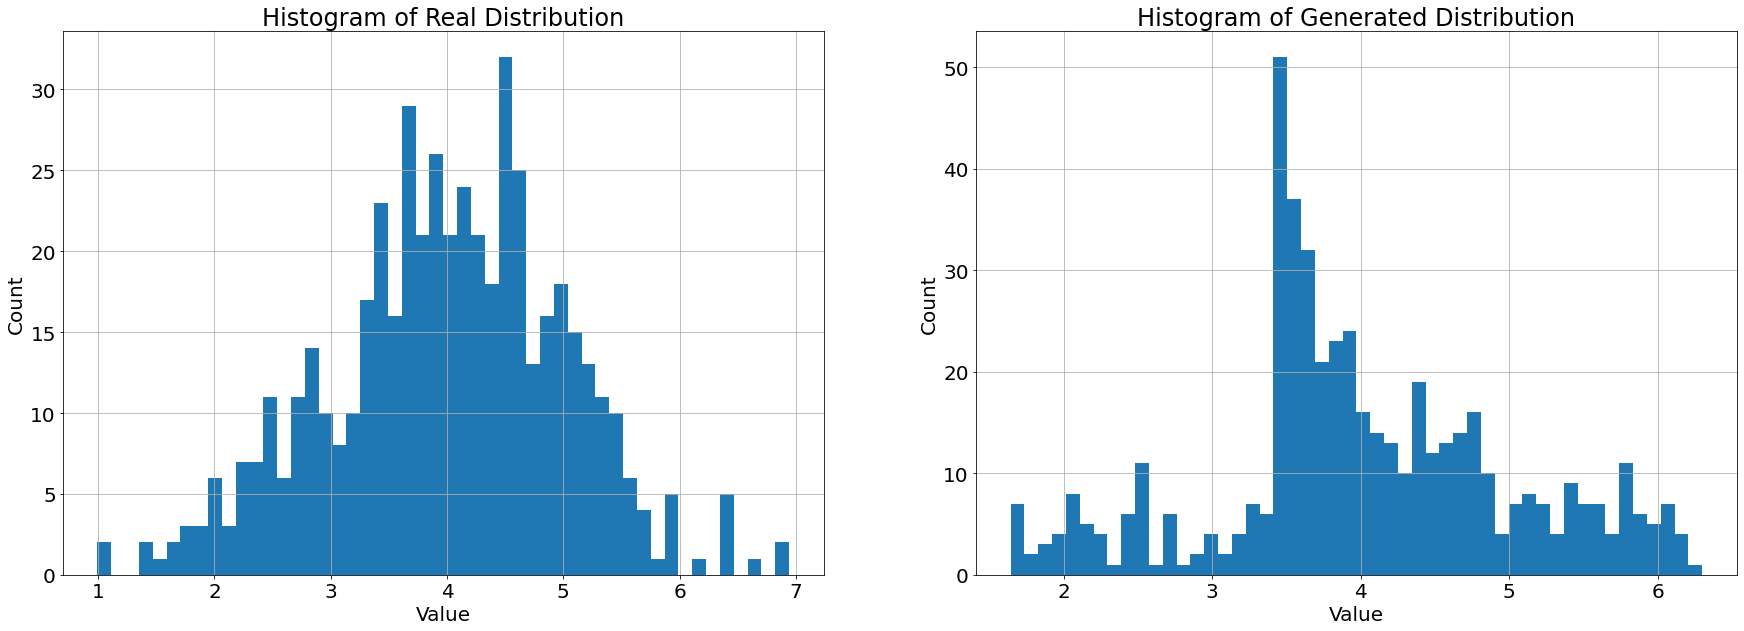

Epoch 29999: D (0.69 real_err, 0.69 fake_err) G (0.69 err); Real Dist ([4.1, 0.99]),  Fake Dist ([4.0, 1.0])


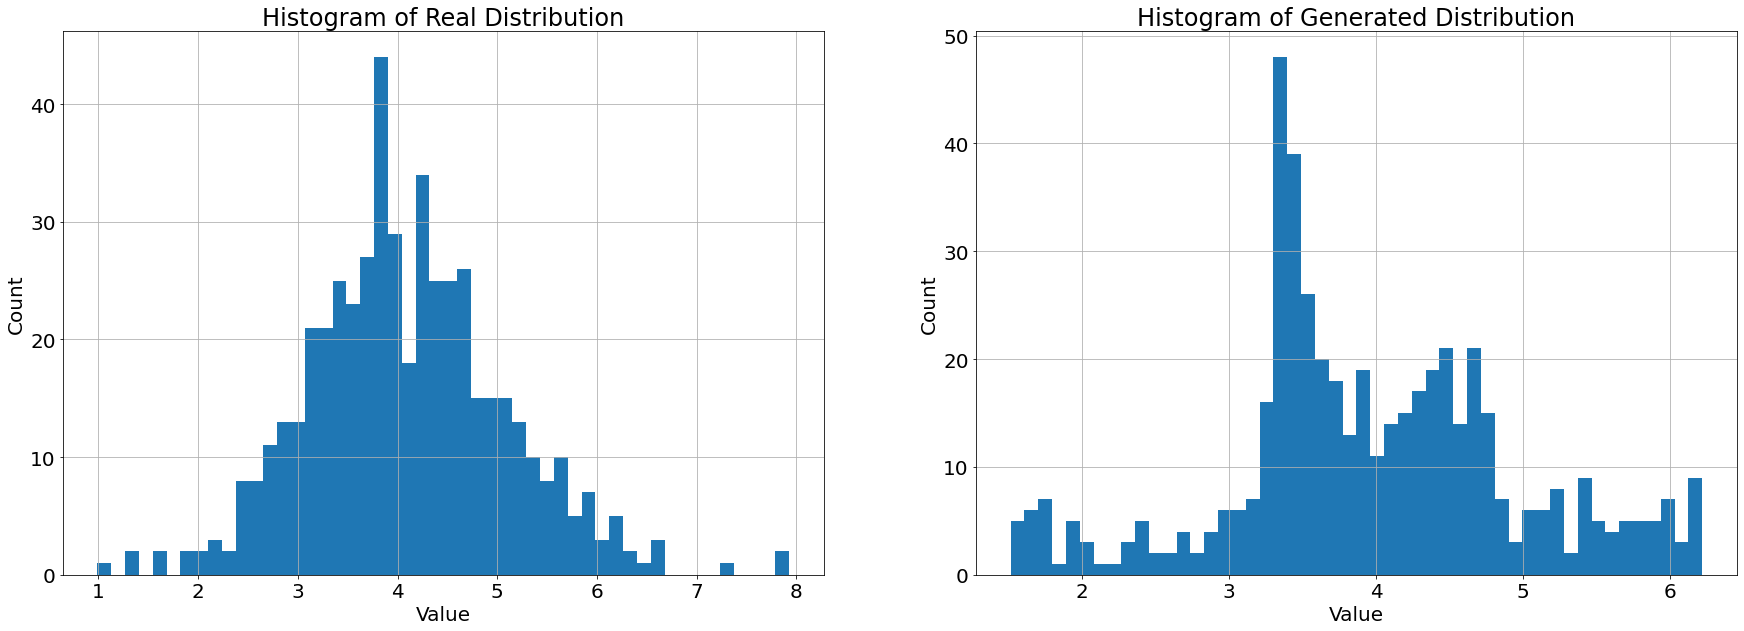

Epoch 34999: D (0.7 real_err, 0.69 fake_err) G (0.7 err); Real Dist ([4.03, 0.98]),  Fake Dist ([4.07, 1.02])


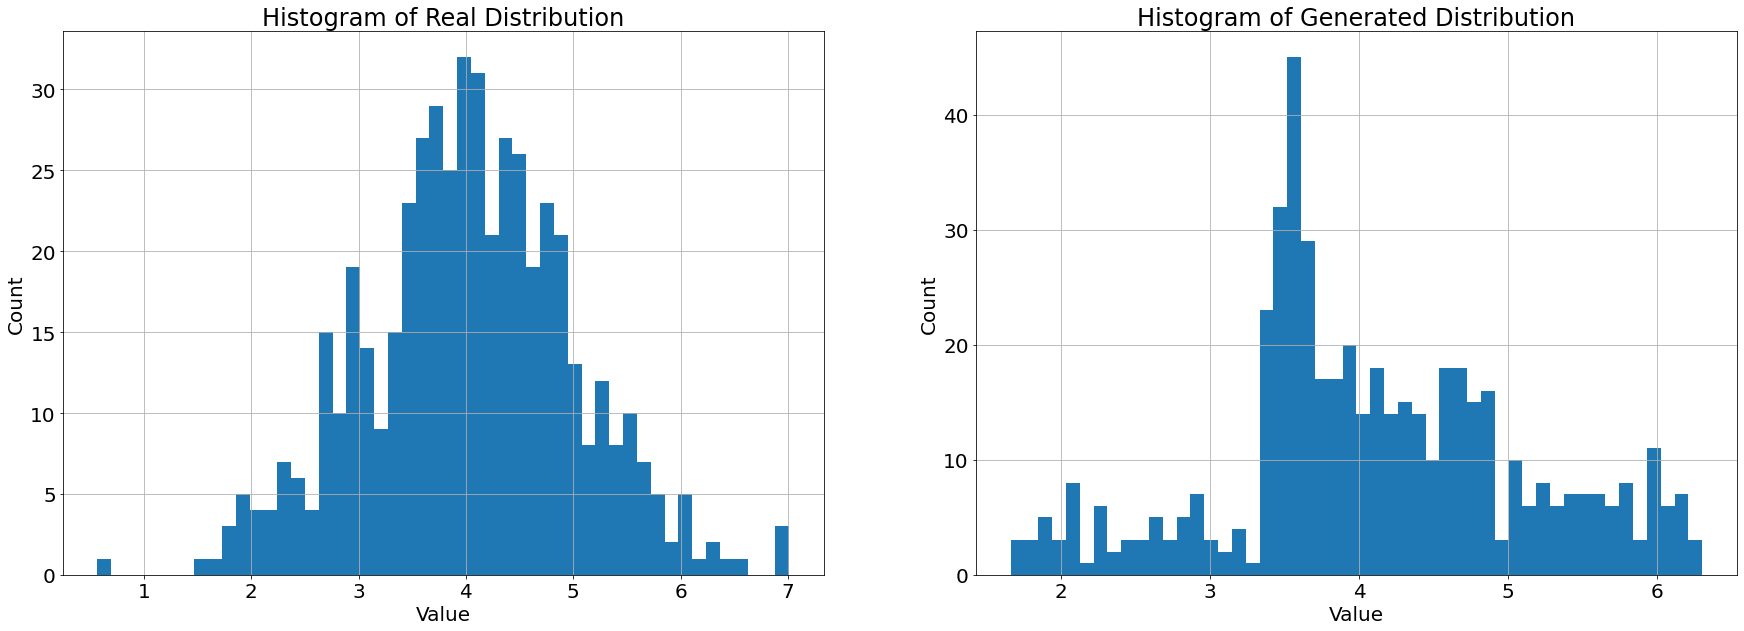

Epoch 39999: D (0.69 real_err, 0.69 fake_err) G (0.7 err); Real Dist ([4.07, 0.98]),  Fake Dist ([3.96, 0.98])


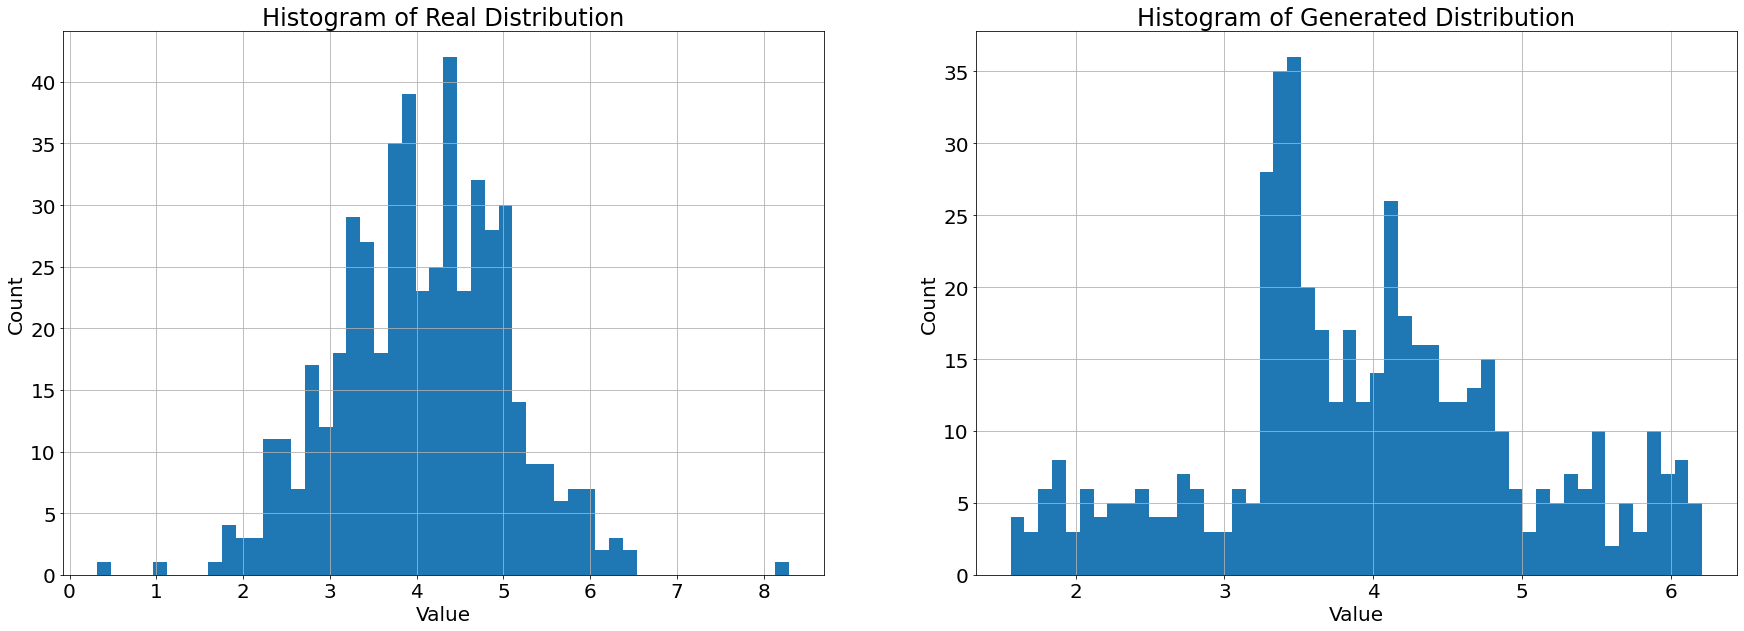

Epoch 44999: D (0.69 real_err, 0.68 fake_err) G (0.7 err); Real Dist ([4.04, 1.0]),  Fake Dist ([4.03, 1.1])


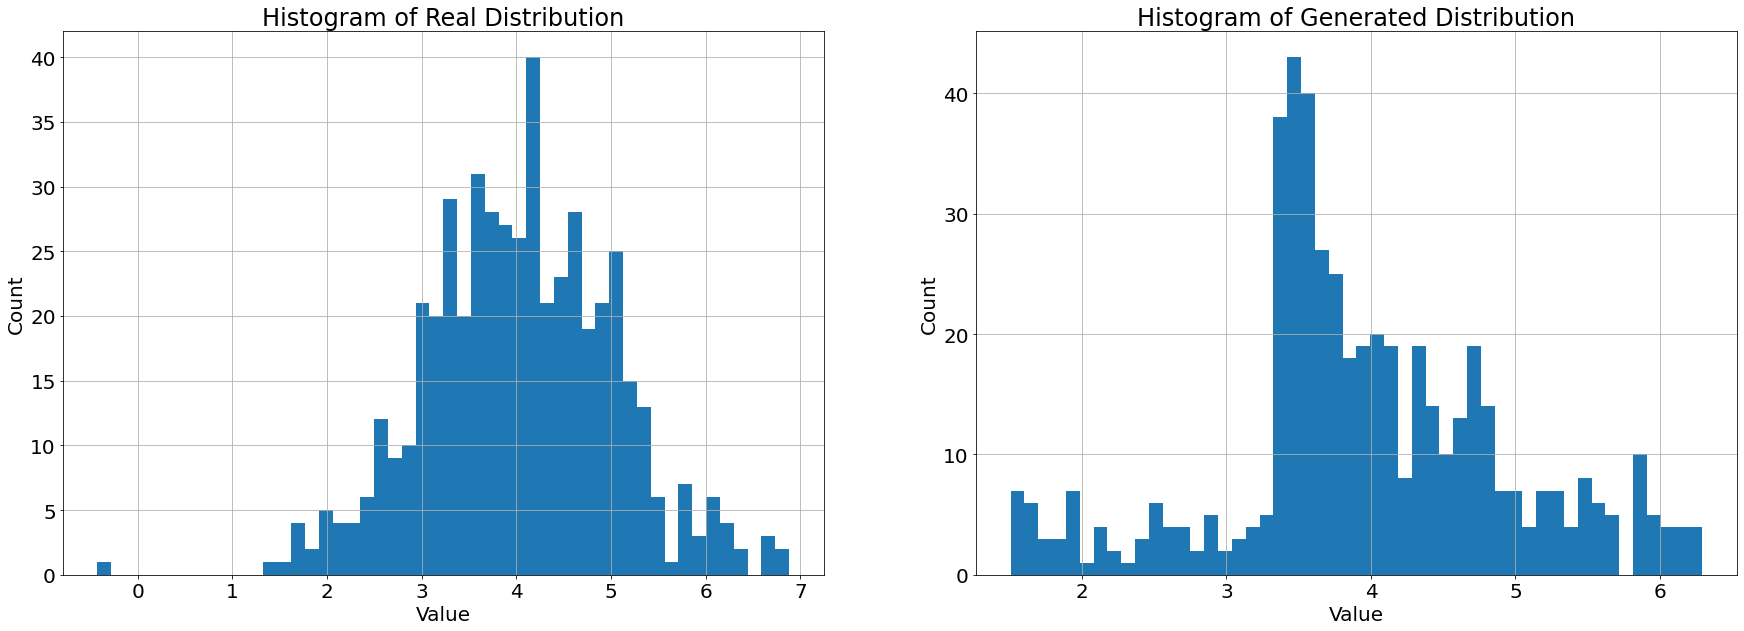

Epoch 49999: D (0.69 real_err, 0.7 fake_err) G (0.69 err); Real Dist ([4.01, 0.97]),  Fake Dist ([4.06, 0.99])


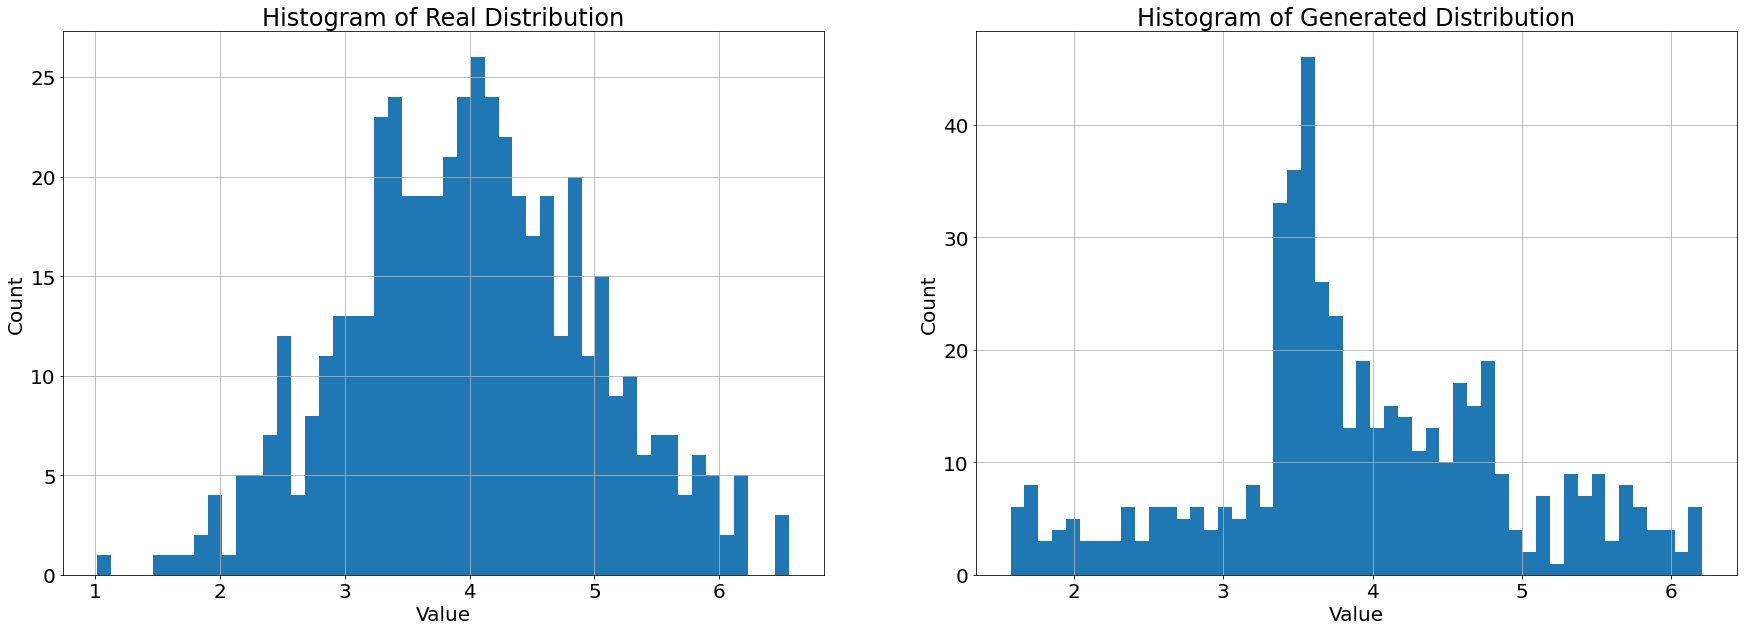

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available else 'cpu'

data_mean = 4
data_stddev = 1

num_epochs = 50000
print_interval = 1000
d_steps = 1
g_steps = 1

preprocess = lambda data: get_moments(data)
d_input_func = lambda x: 4

def d_input_sampler(n, mu, sigma):
    a = torch.Tensor(np.random.normal(mu, sigma, (n, 1)))
    return a

def g_input_sampler():
    return lambda m, n: torch.rand(m, n)

g_input_size = 1
g_hidden_size = 50
g_output_size = 1

d_input_size = 500
d_hidden_size = 50
d_output_size = 1
minibatch_size = d_input_size

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(input_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, output_size))
    def forward(self, x):
        out = self.layer1(x)
        return out

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(input_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, output_size),
                                    nn.Sigmoid())
    def forward(self, x):
        out = self.layer1(x)
        return out

def extract(v):
    return v.data.storage().tolist()


def stats(d):
    return [round(np.mean(d),2), round(np.std(d),2), round(kurtosis(d),2), round(skew(d),2)]

def stats(d):
    return [round(np.mean(d),2), round(np.std(d),2)]


def get_moments(d):
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final



d_learning_rate = 0.0001
g_learning_rate = 0.0001
optim_betas = (0.9, 0.999)

G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size).to(device)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size).to(device)
criterion = nn.BCELoss()
# d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
# g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

sgd_momentum = 0.9
d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

# num_epochs = 50000

for epoch in range(num_epochs):
    for d_index in range(d_steps):
        D.zero_grad()

        d_real_data = d_input_sampler(d_input_size, data_mean, data_stddev).to(device)
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, torch.ones(1).to(device))
        d_real_error.backward()

        gi_sampler = g_input_sampler()
        d_gen_input = gi_sampler(minibatch_size, g_input_size).to(device)
        d_fake_data = G(d_gen_input).detach() 
        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, torch.zeros(1).to(device))
        d_fake_error.backward()
        d_optimizer.step()

    for g_index in range(g_steps):
        G.zero_grad()

        gen_input = gi_sampler(minibatch_size, g_input_size).to(device)
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, torch.ones(1).to(device))

        g_error.backward()
        g_optimizer.step()

    if (epoch+1) % (print_interval*5) == 0:
        print("Epoch {}: D ({} real_err, {} fake_err) G ({} err); Real Dist ({}),  Fake Dist ({})".format(epoch, round(extract(d_real_error)[0],2), round(extract(d_fake_error)[0],2), round(extract(g_error)[0],2), 
                                                                                                          stats(extract(d_real_data)), stats(extract(d_fake_data))))
        
        plt.rcParams["font.size"] = 20
#    if epoch % print_interval == 0:
        values = extract(d_real_data)
        fig, ax = plt.subplots(1,2, figsize = (30,10))
        ax[0].hist(values, bins=50)
        ax[0].set_xlabel('Value')
        ax[0].set_ylabel('Count')
        ax[0].set_title('Histogram of Real Distribution')
        ax[0].grid(True)
        
        values1 = extract(g_fake_data)
        ax[1].hist(values1, bins=50)
        ax[1].set_xlabel('Value')
        ax[1].set_ylabel('Count')
        ax[1].set_title('Histogram of Generated Distribution')
        ax[1].grid(True)
        plt.show()